In [ ]:
import os
import pandas as pd
import numpy as np
import random as rn
from datetime import datetime
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, 
                                     Flatten, TimeDistributed, LSTM, Input, 
                                     Bidirectional, Multiply,
                                     Add, concatenate, Dropout)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.initializers import RandomUniform, Orthogonal
import tensorflow.keras.backend as K

from plotnine import * #ggplot functionality
from typing import Optional, List

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#tf.config.set_visible_devices([], 'GPU')
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
"""
This notebook implements a stacked WaveNet-LSTM architecture that seems to have an upper 
performance threshold of 0.941 regardless of structure changes. Because of this I have added 
a section on possible further work; topics such as switching losses part way through and 
considering more of a many to one or many to many approach but only taking middle predictions

Thanks to siavrez for the Wavenet concept and residual block 
https://www.kaggle.com/siavrez/wavenet-keras

Thanks to Chris Deotte for removing drift from the datasets 
https://www.kaggle.com/cdeotte/data-without-drift

I'd be more than happy to discuss different strategies, look at any possible mistakes, 
or help walk anyone through the code
"""


train = pd.read_csv('/kaggle/input/data-without-drift/train_clean.csv', 
                    dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})

test  = pd.read_csv('/kaggle/input/data-without-drift/test_clean.csv', 
                    dtype={'time': np.float32, 'signal': np.float32})


In [ ]:
class WaveModeler:
    """
    The WaveModeler is designed to set up the data and network upon instantiation. 
    Passing in only the datasets and hyperparameters. Other methods can then be called 
    to fit the model and get different datasets/result.
    
    The implemented network is a stacked Wavenet for feature engineering follow by an LSTM(s). 
    The output of each WaveNet is concatenated with the original raw signal and passed to the LSTM(s). 
    This allows for multiple different kernel sizes/architectures.
    
    """
    def __init__(self, train : pd.DataFrame, test : pd.DataFrame, 
                 group_size : int, 
                 features : List[str],
                 num_filters : List[int], kernel_size : List[int], 
                 repeats : List[int], dilations : List[int], densers : List[int], 
                 LSTMs : List[int],
                 learning_rate : float, metrics : list,
                 the_loss = tf.keras.losses.CategoricalCrossentropy(),
                 normalize = True):
        """
    
        Parameters
        ----------
        train : pd.DataFrame
            training dataset
        test : pd.DataFrame
            testing dataset
        group_size : int
            The length of each sample fed into the model. 
            for the training data this would be (# of groups, group_size, # of predictors). 
            Current code requires sample size to be divisible by group_size
        features : List[str]
            string list of the features used for predicting
        num_filters : List[int]
            integer list of the # of filters for each Wavenet
        kernel_size : List[int]
            integer list of the kernal size for each Wavenet
        repeats : List[int]
            integer list of the amount of times to repeat each Wavenet
        dilations : List[int]
            integer list of the # of stacked layers for each Wavenet
        densers : List[int]
            integer list of the # of units for a Dense layer following each Wavenet 
            (0 for no Dense layer)
        LSTMs : List[int]
            integer list of the units for each LSTM
        learning_rate : float
            starting learning rate for the network
        metrics : list
            list of tensorflow metrics for the model to monitor
        the_loss : TYPE, optional
            the loss funciton of the network for compilation. 
            The default is tf.keras.losses.CategoricalCrossentropy().
        normalize : TYPE, optional
            Whether or not to standardize the data. The default is True.

        Returns
        -------
        None.

        """
        self.train = train
        self.test = test
        self.normalize = normalize
        self.group_size = group_size
        self.features = features
        #Set up the data for modeling
        means = []
        sds = []
        for i in self.features:
            means.append(np.mean(self.train[i]))
            sds.append(np.std(self.train[i]))
            
        self.trainX, self.trainy = self.__SetupData(self.train, means, 
                                                    sds, normalize = self.normalize)
        self.testX = self.__SetupData(self.test, means, 
                                      sds, normalize = self.normalize, 
                                      response = False)
        
        
        #set up the model
        inp = Input(shape=(self.group_size, self.trainX.shape[2]))
        
        #get the first wavenet
        x = Conv1D(num_filters[0], 1, padding='same')(inp)
        x = self.__WaveNetResidualConv1D(num_filters[0], kernel_size[0], dilations[0])(x)
        
        if repeats[0] > 0:
            for _ in range(repeats[0]):
                x = Conv1D(num_filters[0], 1, padding='same')(x)
                x = self.__WaveNetResidualConv1D(num_filters[0],  kernel_size[0], dilations[0])(x)
        if densers[0] > 0:
            x = Dense(densers[0], activation = 'relu')(x)
            
        #concatenate all other wavenets to the first wavenet
        for i in range(len(kernel_size) - 1):
            
            x1 = Conv1D(num_filters[i + 1], 1, padding='same')(inp)
            x1 = self.__WaveNetResidualConv1D(num_filters[i + 1],  kernel_size[i + 1], dilations[i + 1])(x1)
            
            if repeats[i + 1] > 0:
                for _ in range(repeats[i+1]):
                    x1 = Conv1D(num_filters[i + 1], 1, padding='same')(x1)
                    x1 = self.__WaveNetResidualConv1D(num_filters[i + 1],  kernel_size[i + 1], dilations[i + 1])(x1)
            
            if densers[i + 1] > 0:
                x1 = Dense(densers[i + 1], activation = 'relu')(x1)
            x = concatenate([x, x1])
        #concatenate the signal
        x = concatenate([x, inp])        
        #finish it off with an LSTM
        for lstm_size in LSTMs:      
            x = Bidirectional(CuDNNLSTM(lstm_size, return_sequences = True))(x)

        out = Dense(self.trainy.shape[2], activation='softmax')(x)
        self.model = models.Model(inputs=[inp], outputs=[out])
        opt = Adam(lr=learning_rate)
        
        #opt = tfa.optimizers.SWA(opt, start_averaging = 30, average_period = 5)
        self.model.compile(loss=the_loss, optimizer=opt, metrics=metrics)


    def __SetupData(self, df : pd.DataFrame, means : Optional[List[float]], 
                    sds : Optional[List[float]], normalize : bool, response = True):
        """
        A private method designed to clean up the data for modeling

        Parameters
        ----------
        df : pd.DataFrame
            dataset to be cleaned for modeling
        means : Optional[List[float]]
            list of means for each predictor
        sds : Optional[List[float]]
            list of means for each predictor
        normalize : bool
            whether or not to standardize
        response : TYPE, optional
            whether or not to create y. The default is True.

        Returns
        -------
        
        X : np.array
            predictor matrix to be fed into tf.keras
        y : np.array, optional
            if response then the response variable is one-hot encoded and returned
        """
        if self.normalize:
            for i, feats in enumerate(self.features):
                df[feats] = (df[feats] - means[i])/sds[i]
            
        #create 
        df['group'] = df.groupby(df.index//self.group_size, 
                                 sort=False)['signal'].agg(['ngroup'])
        self.ngroups = len(np.unique(df['group']))

        X = np.array(list(df.groupby('group').apply(lambda x: x[self.features].values)))
        print(f'The data shape is {X.shape}')
        if response:
            y = pd.concat([pd.get_dummies(df['open_channels']), 
                           df['group']], axis = 1) #get the dummies
            y = np.array([gr.drop(columns = 'group').values for _, gr in y.groupby('group')]).astype(np.float32)
            print(f'The data shape is {y.shape}')
            return X, y
    
        return X
    
    #this private function was taken from https://www.kaggle.com/siavrez/wavenet-keras
    def __WaveNetResidualConv1D(self, num_filters : int, kernel_size : int, stacked_layer : int):
        """
        Private function designed to create the residual block for the Wavenet

        Parameters
        ----------
        num_filters : int
            number of filters.
        kernel_size : int
            the kernel size.
        stacked_layer : int
            the amount of stacked layers (dilations).

        Returns
        -------
        TYPE
            the created residual block.

        """
        def build_residual_block(l_input):
            resid_input = l_input
            for dilation_rate in [2**i for i in range(stacked_layer)]:
                l_sigmoid_conv1d = Conv1D(
                  num_filters, kernel_size, dilation_rate=dilation_rate,
                  padding='same', activation='sigmoid')(l_input)
                l_tanh_conv1d = Conv1D(
                 num_filters, kernel_size, dilation_rate=dilation_rate,
                 padding='same', activation='relu')(l_input)
                l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
                l_input = Conv1D(num_filters, 1, padding='same')(l_input)
                resid_input = Add()([resid_input ,l_input])
            return resid_input
        return build_residual_block
    
    def fit_model(self, nepochs : int, batch_size : int, callbacks : list, 
                  fit_type : str, split_size = 0.1, seed = 412, **kwargs):
        """
        Used to fit the model. Allowing the user to specify the fitting strategy. 
        Whether that be train, train/val split or cross validation (not yet implemented)

        Parameters
        ----------
        nepochs : int
            number of epochs to run for.
        batch_size : int
            batch size.
        callbacks : list
            any callbacks wanted.
        fit_type : str
            train for training on entire train dataset, cv for cross validation, 
            and otherwise it will do a train/val split.
        split_size : TYPE, optional
            split size if fit_type is train/val. The default is 0.1.
        verbose : TYPE, optional
            verbosity of the model fit. The default is 2.
        seed : TYPE, optional
            seed for the train/val split. The default is 412.

        Returns
        -------
        None.

        """
        
        if fit_type == 'train':
          self.history = self.model.fit(self.trainX, self.trainy, 
                                      epochs = nepochs,
                                      batch_size = batch_size,
                                      callbacks = callbacks,
                                      **kwargs)
        elif fit_type == 'cv':
          #create cross validated splits to loop through and output results
          print('Not Currently Available')
          
        else:
            try:
                self.train_data
            except AttributeError:
                self.train_data, self.val_data, self.train_datay, self.val_datay = train_test_split(self.trainX, self.trainy, 
                                                                                                    test_size=split_size, 
                                                                                                    random_state=seed)
        
            self.history = self.model.fit(self.train_data, self.train_datay, 
                                      epochs = nepochs,
                                      validation_data = (self.val_data, self.val_datay),
                                      batch_size = batch_size,
                                      callbacks = callbacks,
                                      **kwargs)
    
    #Get Methods
    def get_train_preds(self, **kwargs):
        """
        Get predictions on the entire training dataset

        Parameters
        ----------
        **kwargs : TYPE
            any extra paremeters to be fed to tf.keras predict functionality.

        Returns
        -------
        TYPE
            model predictions.

        """
        return self.model.predict(self.trainX, **kwargs)
    
    def get_test_preds(self, **kwargs):
        """
        Get prdictions on the test dataset

        Parameters
        ----------
        **kwargs : TYPE
            any extra paremeters to be fed to tf.keras predict functionality.

        Returns
        -------
        TYPE
            model predictions.

        """
        return self.model.predict(self.testX, **kwargs)
    
    def get_train_data(self):
        """
        Get the training data if train/val split was used
        
        Returns
        -------
        The predictor matrix along with the response one-hot matrix
        """
        return self.train_data, self.train_datay
    
    def get_val_data(self):
        """
        Get the validation data if train/val split was used
        
        Returns
        -------
        The predictor matrix along with the response one-hot matrix
        """
        return self.val_data, self.val_datay
    
    def get_model(self):
        """
        Get the model

        Returns
        -------
        tf.keras model

        """
        return self.model
    
    def get_history(self):
        """
        Get the history from the latest model fit

        Returns
        -------
        tf.keras history.

        """
        return self.history
    
    def get_trainX(self):
        """
        Get the full training predictor matrix

        Returns
        -------
        predictor matrix.

        """
        return self.trainX
    
    def get_testX(self):
        """
        Get the full test predictor matrix

        Returns
        -------
        predictor matrix

        """
        return self.testX



"""
A weighted version of categorical_crossentropy for keras (2.0.6). 
This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
#seeding
the_seed = 7456
tf.random.set_seed(the_seed)
np.random.seed(the_seed)
rn.seed(the_seed)
os.environ['PYTHONHASHSEED'] = str(the_seed)

#setting up the session
K.clear_session()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

#compute weights based on class frequency
#sample_weights = compute_sample_weight(class_weight='balanced', y=train.open_channels)
frequencies = train.open_channels.value_counts()
wgts = (frequencies.mean()/frequencies).values

learning_rate = 0.001
#Instantiate a model instance
modeler = WaveModeler(train, test, 2000, ['signal'],
                      num_filters = [12, 12, 12, 12],
                      kernel_size = [24, 6, 3, 1],
                      repeats = [0, 0, 0, 1],
                      dilations =  [8, 8, 8, 8],
                      densers = [4, 4, 4, 4],
                      LSTMs = [256, 256],
                      learning_rate = learning_rate,
                      the_loss = weighted_categorical_crossentropy(wgts),
                      metrics = [tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall')])

#modeler.get_model().summary()

"""
In my experience the LSTM's struggled to generalize better to drifted data.
If the goal is to have a similar structure generalize in such a manner 
perhaps it would be better to switch over to Dense layer(s) 
and rely more heavily on the WaveNets
"""

In [ ]:
#Define the Keras LR Scheduler Callback
def lrs(epoch):
    if epoch<10:
        lr = learning_rate
    else:
        lr = learning_rate/2
    return lr


lr_schedule = LearningRateScheduler(lrs)

#Define the Keras Checkpoint Callback
filepath = '/kaggle/input/StackedWavenetLSTM.hdf5'
save_checkpoint = ModelCheckpoint(filepath, monitor='val_recall', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='max', period=1)

# Define the Keras TensorBoard callback.
logdir=os.path.join(
    "logs",
    "fit",
    datetime.now().strftime("%Y%m%d-%H%M%S"),
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)



modeler.fit_model(nepochs = 25, batch_size = 10,
                  fit_type = 'train_val',
                  split_size = 0.1,
                  callbacks = [lr_schedule, save_checkpoint, tensorboard_callback],
                  verbose = 0)
#K.set_value(model.optimizer.lr, np.float32(0.0005))

#%load_ext tensorboard
#%tensorboard --logdir logs
#http://localhost:6006/

In [ ]:
#getting different models
model = modeler.get_model()
model = tf.keras.models.load_model('/kaggle/input/StackedWavenetLSTM.hdf5', 
                                   custom_objects = {'loss' : weighted_categorical_crossentropy(wgts)})
#model = tf.keras.models.load_model('StackedWavenetLSTM_softF1.hdf5', 
#                                   custom_objects = {'macro_soft_f1' : macro_soft_f1})

#can also call modeler.get_train_predictions(batch_size = 1) to get prediction on the latest fit
trainX = modeler.get_trainX()
testX = modeler.get_testX()
trainPreds = model.predict(trainX, batch_size = 1)#lowering batchsize for memory issues
testPreds = model.predict(testX, batch_size = 1)
#np.save('latest_train_preds.npy', trainPreds)
#np.save('latest_test_preds.npy', testPreds)


train['preds'] = np.argmax(trainPreds, axis=2).reshape(-1)
test['preds'] = np.argmax(testPreds, axis=2).reshape(-1)

ggplot(train.sample(50000)) + geom_point(aes(x = 'time', y = 'signal', color = 'preds'))
ggplot(test.sample(n = 50000)) + geom_point(aes(x = 'time', y = 'signal', color = 'preds'))

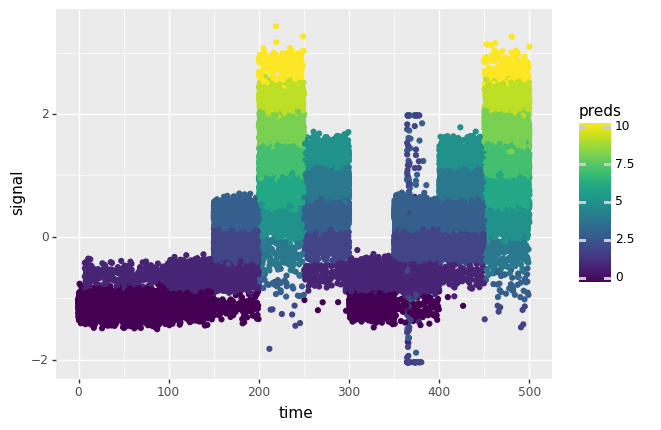
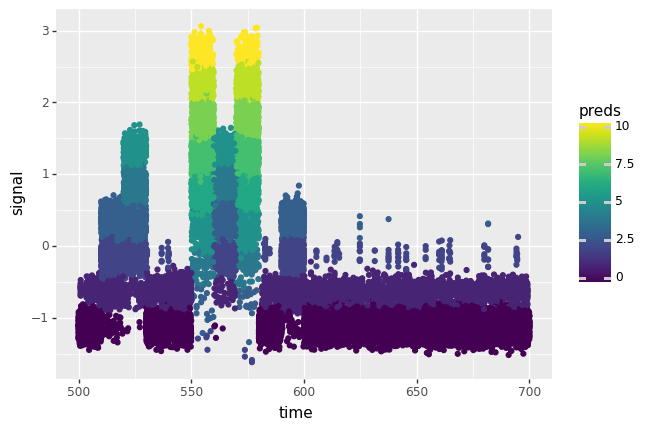

In [ ]:
#check F1 Scores
f1_score(train['open_channels'],  train['preds'], average = 'macro')
f1_score(train['open_channels'],  train['preds'], average = None)
#performance falls off above 5 channels


#make predictions file
sub  = pd.read_csv('/kaggle/input/liverpool-ion-switching/sample_submission.csv', dtype={'time': str})
sub.open_channels = np.argmax(testPreds, axis=2).reshape(-1)
sub.to_csv('/kaggle/input/final_waveNetLSTM_softF1.csv', index = False)

# **Possible Further Work**

I did not dig too deep into many of these concepts below however they seem worth looking into. First the Macro Soft F1 loss performed poorly (possibly due to my batch size) unless categorical crossentropy first trained the weights however it shows promise in getting slightly better performance as its focus is on a modified Macro F1. Visualizing mistakes also offers some insight as does checking F1 performance at different points of a sample 

In [ ]:
model = tf.keras.models.load_model('/kaggle/input/StackedWavenetLSTM.hdf5', 
                                   custom_objects = {'loss' : weighted_categorical_crossentropy(wgts)})


#loss function taken from Mohamed-Achref Maiza's post on soft f1 loss
#https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d

#It can be beneficial to recompile the model using soft f1 and further optimizing the network 
#after crossentropy given Macro F1 is the evaluation metric
#may be valuable to consider a higher batch size with this loss
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost


model.compile(loss=macro_soft_f1, 
              optimizer=Adam(lr=learning_rate/2), 
              metrics= [tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')])

#to run the model outside of the class pull out the needed data
train_data, train_datay = modeler.get_train_data()
val_data, val_datay = modeler.get_val_data()

filepath = '/kaggle/input/StackedWavenetLSTM_softF1.hdf5'
save_checkpoint = ModelCheckpoint(filepath, monitor='val_recall', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='max', period=1)




history = model.fit(train_data, train_datay, 
                                      epochs = 10,
                                      validation_data = (val_data, val_datay),
                                      batch_size = 10,
                                      callbacks = [save_checkpoint],
                                      verbose = 1)

In [ ]:
#visualize where the mistakes were
bad = train.query('open_channels != preds')
ggplot(bad) + geom_point(aes(x = 'time', y = 'signal', color = 'preds'))

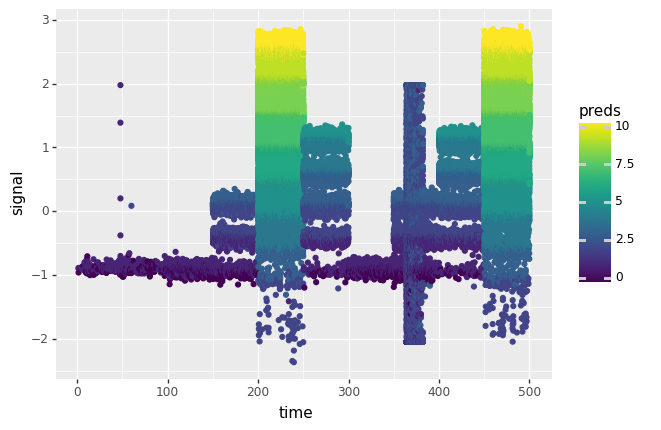
It becomes rather apparent as shown in the F1 score that the peak groups are where most mistakes happen. Perhaps it would also makes sense to handle extreme outliers in some groups that are most likely measurement errors

In [ ]:
#Look into if a many to one strategy may be better
train['groupings'] = np.repeat(np.arange(0, train.shape[0]//2000), 2000)
first100 = train.groupby('groupings', as_index=False).head(10)
last100 =  train.groupby('groupings', as_index=False).tail(10)
middle100 = train.groupby('groupings', as_index=False).apply( lambda df : df.iloc[950:1050])

f1_score(middle100['open_channels'],  middle100['preds'], average = 'macro')
f1_score(middle100['open_channels'],  middle100['preds'], average = None)



Using StackedWavenetLSTM_softF1, Macro F1 was calculated on the first 100 of each sample, the middle 100, and then the last 100.

* First F1  : 0.93511
* Middle F1 : 0.93984
* Last F1   : 0.93793

Looking at just the last 50 seconds (one of the peak groups) this issue becomes much more apparent  
  
  

* First F1  : 0.77191  
* Middle F1 : 0.79262  
* Last F1   : 0.75379  